In [1]:
from bs4 import BeautifulSoup
import re
import csv
import requests
import pandas as pd
from urllib.request import urlopen
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Webscraping to collect the data from the url

We are performing web scraping using Beautifulsoup to collect the data from the API directly, and store it in human readable pandas dataframe.

In [2]:
url = 'https://archive.ics.uci.edu/ml/datasets/Adult'
req = requests.get(url)
content = req.text
soup = BeautifulSoup(content,'html.parser')
data_url='https://archive.ics.uci.edu/ml/'
for link in soup.find_all('a',attrs={'href': re.compile("../machine-learning-databases/adult/")}):
  data_url = data_url+ link.get('href')[3:]
  break
print (data_url)
data_req = requests.get(data_url)
data_content = data_req.text
soup1 = BeautifulSoup(data_content,'html.parser')

for link in soup1.find_all('a',attrs={'href':re.compile("adult.data")}):
  adult_dataset_url = data_url + link.get('href')



https://archive.ics.uci.edu/ml/machine-learning-databases/adult/


We are replacing the feature name with the meaningful names collected from the Data-description given in the url

In [3]:
df = pd.read_csv(adult_dataset_url,header=None)
#Rename the columns according to the dataset description
df.rename(columns={0:'age',1:'workclass',2:'fnlwgt',
                   3:'education',4:'education-num',5:'marital-status',
                   6:'occupation',7:'relationship',8:'race',9:'sex',
                   10:'capital-gain',11:'capital-loss',12:'hours-per-week',
                   13:'native-country',14:'income'},inplace=True)

In [4]:
df.head(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [5]:
##remove all leading and trailing whitespaces from the column values
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [7]:
##Observe the target variable
df['income'].value_counts()

<=50K    24720
>50K      7841
Name: income, dtype: int64

We are checking the distribution of target variable to verify whether the data is balanced or not

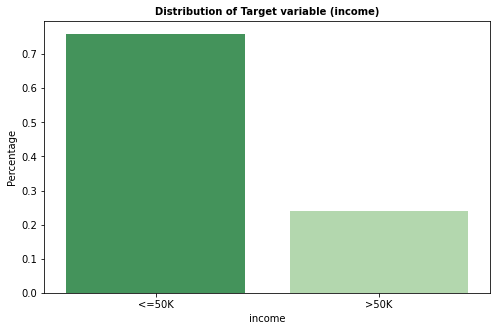

In [8]:
plt.figure(figsize = (8,5))
plt.title('Distribution of Target variable (income)', fontsize=10, fontweight='bold')
eda_percentage = df['income'].value_counts(normalize = True).rename_axis('income').reset_index(name = 'Percentage')

ax = sns.barplot(x = 'income', y = 'Percentage', data = eda_percentage.head(10), palette='Greens_r')

From the observation of target variable we can see there is class imbalance present. So, we have to deal with this before applying any machine learning algorithm, otherwise the algorithm will tend to learn more about the majority class

We are mapping the target variable to binary values for the ease of usage

In [9]:
#Mapping binary values to the target variable
df['income']=df['income'].map({'<=50K': 0, '>50K': 1})

In [10]:
#There are no null values but we observe some variable with ?. We will replace them with NAN value
df = df.replace('?',np.nan)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      30718 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  31978 non-null  object
 14  income          32561 non-null  int64 
dtypes: int64(7), object(8)
memory usage: 3.7+ MB


We observe that after replacing the '?' values with *NAN*, there are some missing values in *workclass*, *occupation*, and *native-country* column. We need to treat these missing values.

# Impute Missing Values


Since, workclass, occupation, and native-country are the features with missing values, and they are categorical variable, we will replace the missing values with mode of that particular feature

In [11]:
for c in ['workclass', 'occupation', 'native-country']:
    df[c].fillna(df[c].mode()[0], inplace=True)

In [12]:
df.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

We Observe that after replacing the missing values, there are no more missing value present in the dataset.

# Outlier Treatment

Before proceeding we have to check for the potential outliers present in the dataset, otherwise it can affect your prediction. We will produce some box-plots to see if there are any outliers present in the dataset

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


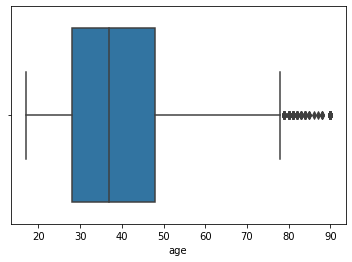

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


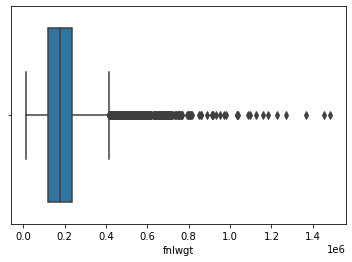

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


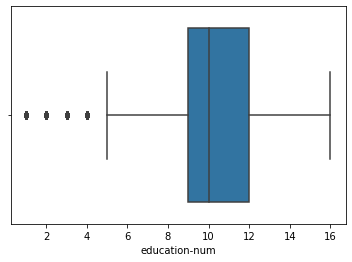

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


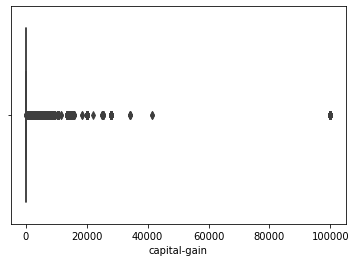

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


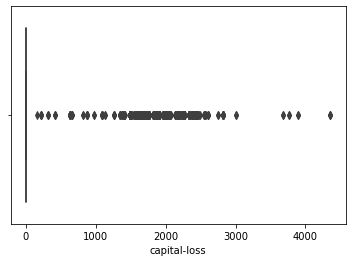

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


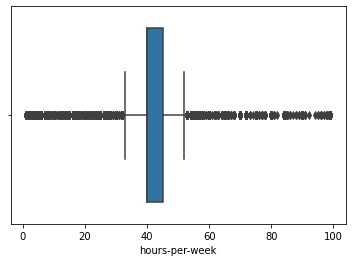

In [13]:
columns_to_be_checked = ['age','fnlwgt','education-num','capital-gain','capital-loss','hours-per-week']
for x in columns_to_be_checked:
  sns.boxplot(df[x])
  plt.show()

From the box plots, we observe there are some outliers in the features. Capital-gain and Capital-loss needs to be handled differently as we need to see the values other than zeros. We will use IQR to handle the outlier in the below section. Education-num does not have any significant amount of outliers, hence that can be ignored

Observe the boxplots for capital-loss and capital-gain where both are not equals to 0

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


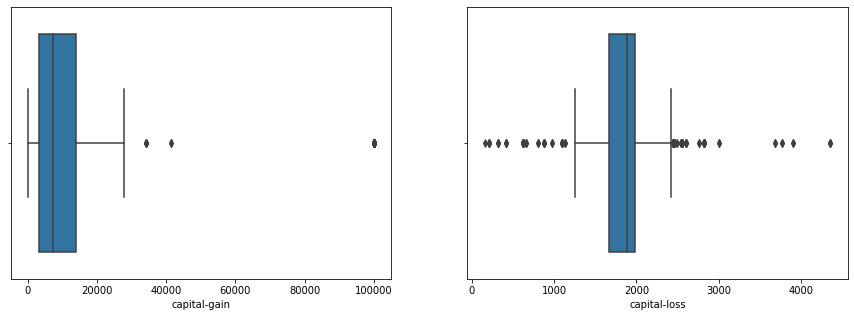

In [14]:
df_capital_loss_wo_zero = df.loc[df['capital-loss']!=0,:]
df_capital_gain_wo_zero = df.loc[df['capital-gain']!=0,:]

plt.figure(figsize=(15,5))
plt.subplot(121)
sns.boxplot(df_capital_gain_wo_zero['capital-gain'])

plt.subplot(122)
sns.boxplot(df_capital_loss_wo_zero["capital-loss"])

In [15]:
filtered_cols = ['age','fnlwgt','capital-gain','capital-loss','hours-per-week']
lower_limits=[]
upper_limits=[]
IQR_values=[]

for i in range(len(filtered_cols)):
    
    Q1=df[filtered_cols[i]].quantile(0.25) 
    Q3=df[filtered_cols[i]].quantile(0.75) 
    IQR=Q3-Q1 
    IQR_values.append(IQR)
    lower_limit=Q1-(1.5*IQR) 
    lower_limits.append(lower_limit)
    upper_limit=Q3+1.5*IQR 
    upper_limits.append(upper_limit)

Now check the IQR table

In [16]:
IQR_table=pd.DataFrame({"columns":filtered_cols,"lower_limits":lower_limits,
                        "upper_limits":upper_limits,"IQR_values":IQR_values})
IQR_table 

,columns,lower_limits,upper_limits,IQR_values
0,age,-2.0,78.0,20.0
1,fnlwgt,-61009.0,415887.0,119224.0
2,capital-gain,0.0,0.0,0.0
3,capital-loss,0.0,0.0,0.0
4,hours-per-week,32.5,52.5,5.0


As mentioned earlier, we will consider capital-gain and capital-loss value which is not equals to 0.

In [17]:
Q1_capital_loss=df[df["capital-loss"]!=0]["capital-loss"].quantile(0.25)
Q3_capital_loss=df[df["capital-loss"]!=0]["capital-loss"].quantile(0.75)
IQR_loss=Q3_capital_loss-Q1_capital_loss
lower_limit_loss=Q1_capital_loss-(1.5*IQR_loss)
upper_limit_loss=Q3_capital_loss+(1.5*IQR_loss)

print("Capital-Loss Lower Limit :",lower_limit_loss)
print("Capital-Loss Upper Limit :",upper_limit_loss)

print ("========================")

Q1_capital_gain=df[df["capital-gain"]!=0]["capital-gain"].quantile(0.25)
Q3_capital_gain=df[df["capital-gain"]!=0]["capital-gain"].quantile(0.75)
IQR_gain=Q3_capital_gain-Q1_capital_gain
lower_limit_gain=Q1_capital_gain-(1.5*IQR_gain)
upper_limit_gain=Q3_capital_gain+(1.5*IQR_gain)

print("Capital-Gain Lower Limit :",lower_limit_gain)
print("Capital-Gain Upper Limit:",upper_limit_gain)

Capital-Loss Lower Limit : 1214.5
Capital-Loss Upper Limit : 2434.5
Capital-Gain Lower Limit : -12598.5
Capital-Gain Upper Limit: 30093.5


Now we will be identifying the outliers for this two features. There will be two conditions: when capital-loss/capital-gain not equals to 0 and it is less than lower limit, or its not equals to 0 and it is greater than the upper limit. This outliers we need to remove from the dataset

In [18]:
outlier_capital_gain = ((df["capital-gain"]!=0 )& (df["capital-gain"]<lower_limit_gain )) | ((df["capital-gain"]!=0 )& (df["capital-gain"]>upper_limit_gain ))
outlier_capital_loss = ((df["capital-loss"]!=0 )& (df["capital-loss"]<lower_limit_loss)) | ((df["capital-loss"]!=0 )& (df["capital-loss"]>upper_limit_loss ))

In [19]:
df.loc[outlier_capital_gain,"capital-gain"]=df_capital_gain_wo_zero["capital-gain"].mode()[0]
df.loc[outlier_capital_loss,"capital-loss"]=df_capital_loss_wo_zero["capital-loss"].mode()[0]

Remove the outlier for age, fnlwgt

In [20]:
df.drop(df[df["age"]>upper_limits[0]].index,inplace=True) 
df.drop(df[df["fnlwgt"]>900000].index,inplace=True) 

In [21]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,32398.0,38.384592,13.332532,17.0,28.0,37.0,47.00,78.0
fnlwgt,32398.0,189341.510062,103056.141558,12285.0,117847.5,178469.5,236988.75,889965.0
education-num,32398.0,10.082999,2.568359,1.0,9.0,10.0,12.00,16.0
capital-gain,32398.0,655.349898,2693.989598,0.0,0.0,0.0,0.00,27828.0
capital-loss,32398.0,87.256096,397.455240,0.0,0.0,0.0,0.00,2415.0
hours-per-week,32398.0,40.491357,12.297511,1.0,40.0,40.0,45.00,99.0
income,32398.0,0.241126,0.427773,0.0,0.0,0.0,0.00,1.0


Find the correlation between the variables

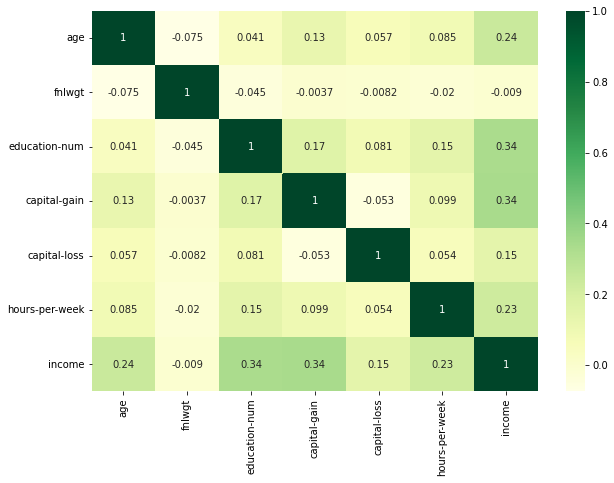

In [22]:
# This heatmap shows the Correlation between the different variables
plt.rcParams['figure.figsize'] = [10,7]
sns.heatmap(df.corr(), annot = True, color = 'blue', cmap = 'YlGn');

We dont see any highly correlated features present in the dataset from the above correlation matrix.

# Encode categorical variable and prepare the dataset for training

In [23]:
categorical_features = ['workclass','education', 'marital-status', 'occupation', 'relationship',
               'race', 'sex','native-country']

Check the relationship of the categorical variable with target variable

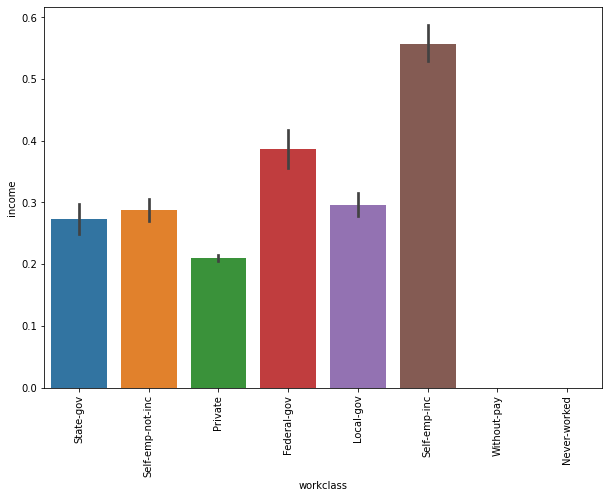

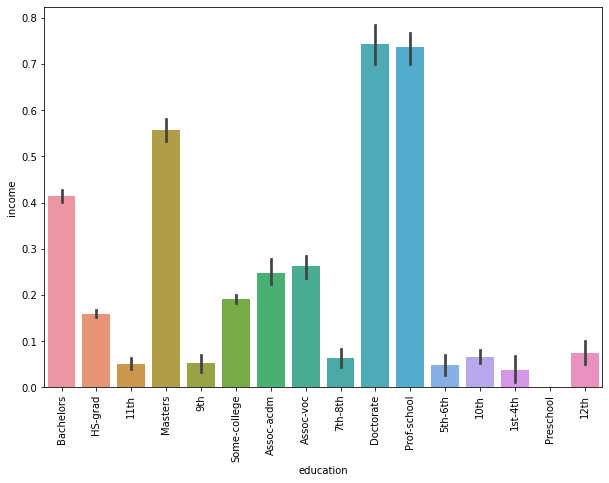

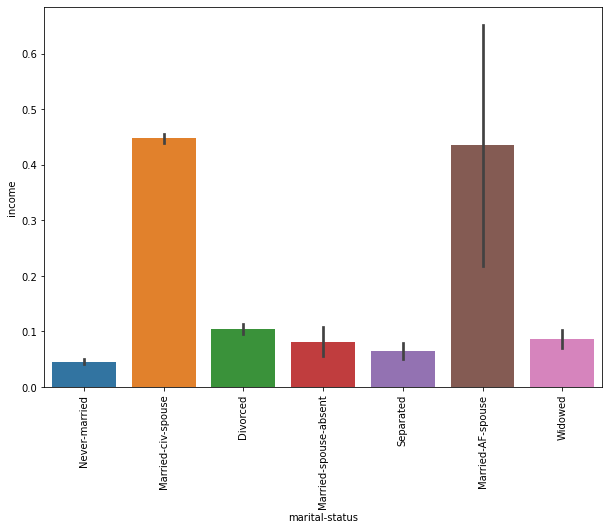

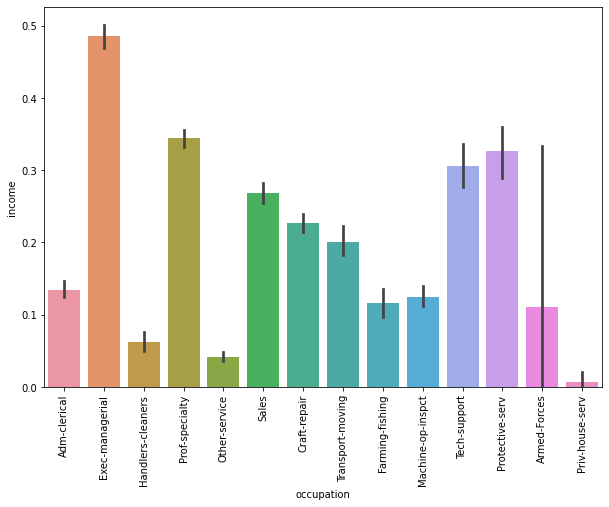

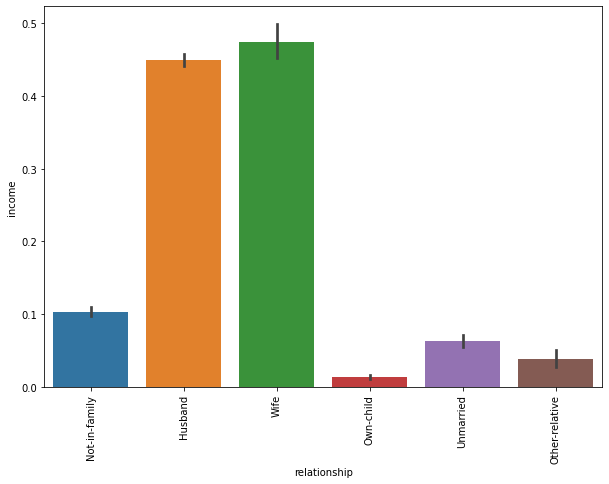

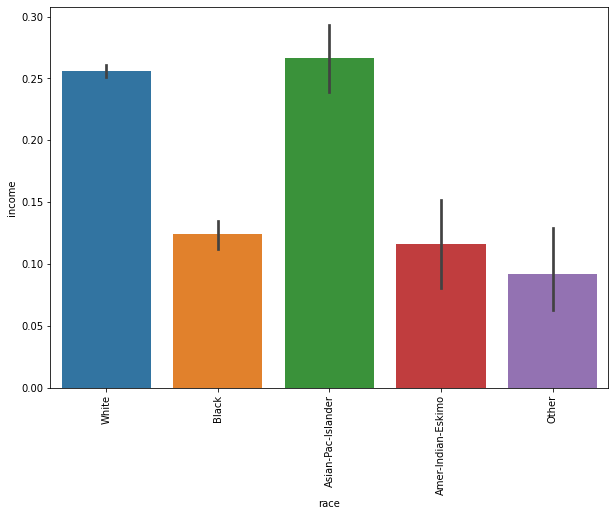

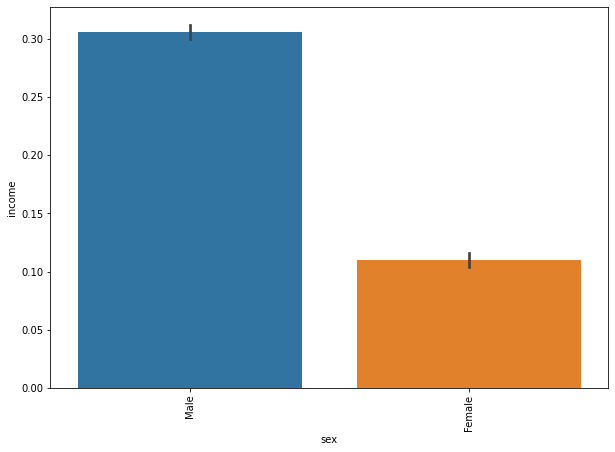

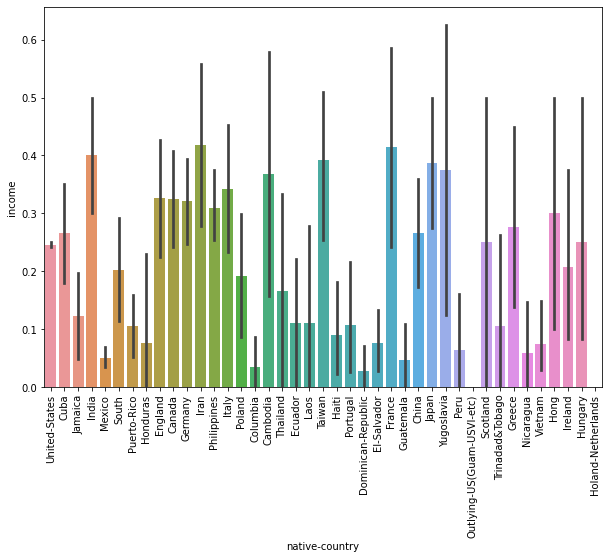

In [24]:
for i in categorical_features:
  sns_grad = sns.barplot(x = df[i], y = df['income'], data = df)
  plt.setp(sns_grad.get_xticklabels(), rotation=90)
  plt.show()

 

1.   For workclass-income visualization, we can see there *Without-pay* and *Never-worked* have no entry against income.
2.   For education-income visualization, we can see *pre-school* have no significant income. 
3. For occupation-income visualization, we observe that *Priv-house-serv* don't have significant contribution in income.
4. For relationship-income visualization, *own-child* do not have significant contribution.
5. For native-country vs income visualization, *Outlying_US*, and *Holand-Netherlands* do not have significant contirbution.





ENCODE the Categorical variables

In [25]:
le = LabelEncoder()
for c in categorical_features:
  le.fit(df[c])
  df[c] = le.transform(df[c])
df.head(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,6,77516,9,13,4,0,1,4,1,2174,0,40,38,0
1,50,5,83311,9,13,2,3,0,4,1,0,0,13,38,0
2,38,3,215646,11,9,0,5,1,4,1,0,0,40,38,0
3,53,3,234721,1,7,2,5,0,2,1,0,0,40,38,0
4,28,3,338409,9,13,2,9,5,2,0,0,0,40,4,0


Split the data using train-test split

In [26]:
X = df.drop(['income'], axis=1)
y = df['income']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

Perform Feature Scaling

In [27]:
scaler = StandardScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns = X.columns)

# Logistic Regression Model

We will use Logistic Regression model to perform the classification

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

model_log = LogisticRegression()
model_log.fit(X_train, y_train)
y_pred = model_log.predict(X_test)

print('Accuracy score of logistic Regression Model: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

print ("=================")
#Printing Classification Report
print(classification_report(y_test, y_pred))

Accuracy score of logistic Regression Model: 0.8198
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      4923
           1       0.69      0.45      0.54      1557

    accuracy                           0.82      6480
   macro avg       0.77      0.69      0.72      6480
weighted avg       0.81      0.82      0.80      6480



We can see Using Logistic Regression on the original dataset works poorly on the minority class, as the dataset is imbalanced. Though the accuracy is coming nearly 82%, we can see Precision, Recall, and F1-score for minority class is low. For an imbalanced class problem we can not use accuracy as the ideal metric, we have to check class-specific precision, recall, and F1-score.

Now, we will perform SMOTE oversampling to generate some synthetic data and then perform the logistic regression model. We only perform the oversampling on the training data, not on the test data

In [29]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_train_os, y_train_os = oversample.fit_resample(X_train, y_train)

## Logistic Regression Model with Oversampled Dataset

Now perfrom the same logistic regression on the above oversampled dataset

In [30]:
model_log_os = LogisticRegression()
model_log_os.fit(X_train_os, y_train_os)
y_pred_os = model_log_os.predict(X_test)

print('Accuracy score of logistic Regression Model after perfroming oversampling: {0:0.4f}'. format(accuracy_score(y_test, y_pred_os)))

print ("=================")
#Printing Classification Report
print(classification_report(y_test, y_pred_os))

Accuracy score of logistic Regression Model after perfroming oversampling: 0.7691
              precision    recall  f1-score   support

           0       0.92      0.77      0.83      4923
           1       0.51      0.78      0.62      1557

    accuracy                           0.77      6480
   macro avg       0.71      0.77      0.73      6480
weighted avg       0.82      0.77      0.78      6480



We can observe, the accuracy score of the oversampled dataset decreased to 77%, but for the minority class, we can see a huge improvement in terms of recall, precision, and F1-score. That means the model is able to distinguish well between the classes despite the imbalance in the original dataset. We will consider this model as our 1st model.

## XGBoost Model

We will use XGBoost model as our 2nd model to perform the classification. From the above experience we will directly use the oversampled dataset for our purpose, because we don't want to perform the classification on imbalanced dataset.

In [31]:
from xgboost import XGBClassifier

model_xgb = XGBClassifier()
model_xgb.fit(X_train_os, y_train_os)

y_pred_xgb = model_xgb.predict(X_test)
print ("The accuracy of model 2 : ",accuracy_score(y_test, y_pred_xgb))

print ("==================")
print (classification_report(y_test,y_pred_xgb))

The accuracy of model 2 :  0.8234567901234567
              precision    recall  f1-score   support

           0       0.94      0.82      0.88      4923
           1       0.60      0.82      0.69      1557

    accuracy                           0.82      6480
   macro avg       0.77      0.82      0.78      6480
weighted avg       0.85      0.82      0.83      6480



We can see XGboost model performs much better than logistic regression model, becuase of its ensemble learning architecture. XGBoost works in boosting technique, which helps the model to reduce bias, hence model learns well. This reflects in the above the classification report.

Now we will perform 5-fold cross validation to check whether our model is overfitted or not

## Cross Validation on XGBoost Model

In [32]:
from sklearn.model_selection import cross_val_score,KFold

kf=KFold(n_splits=5)

score=cross_val_score(model_xgb,X_train,y_train,cv=kf)

print("Cross Validation Scores are in XGBoost model {}".format(score))
print("Average Cross Validation score in XGBoost model :{}".format(score.mean()))

Cross Validation Scores are in XGBoost model [0.85706019 0.86496914 0.86053241 0.86687247 0.86745128]
Average Cross Validation score in XGBoost model :0.8633770958237162


From the cross validation score we can see our model is well generalized, hence it is not overfitted.

## Cross Validation on Logistic Regression Model

In [33]:
from sklearn.model_selection import cross_val_score,KFold

kf=KFold(n_splits=5)

score=cross_val_score(model_log_os,X_train,y_train,cv=kf)

print("Cross Validation Scores are in Logistic Regression model {}".format(score))
print("Average Cross Validation score in Logistic Regression model :{}".format(score.mean()))

Cross Validation Scores are in Logistic Regression model [0.82465278 0.82484568 0.82561728 0.82596952 0.82558364]
Average Cross Validation score in Logistic Regression model :0.8253337790568882


From the above cross validation score, we can see our Logistic Regression Model is not overfitted as well. In 5-fold cross validation we did not see an abrupt changes in the scores. Hence we can conclude both our models are trained well, and they are not overfitted

## ROC Curve to check which model is better

We will plot ROC curve and check the Area Under Curve (AUC). The model with more AUC, will be treated as the best model between these two.

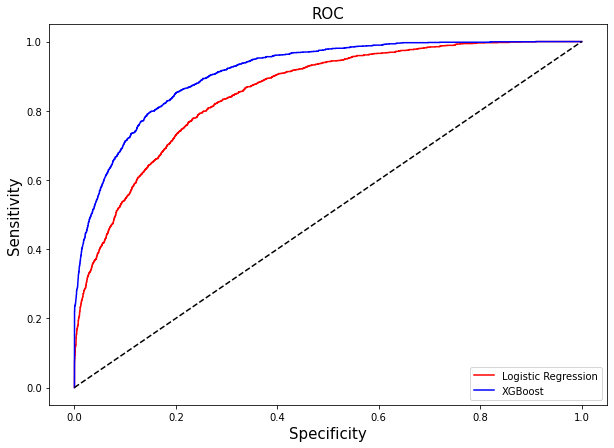

In [34]:
from sklearn import metrics
models = [model_log_os,model_xgb]
model_names = ['Logistic Regression', 'XGBoost']

plt.rcParams['figure.figsize'] = [10,7]
color = ['red','blue']

plt.title("ROC", fontsize = 15)
plt.xlabel("Specificity", fontsize = 15)
plt.ylabel("Sensitivity", fontsize = 15)

for i, model in enumerate(models) :
    prob = model.predict_proba(X_test)
    prob_positive = prob[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, prob_positive)
    plt.plot(fpr, tpr, color = color[i])
    plt.gca().legend(model_names, loc = 'lower right', frameon = True)

plt.plot([0,1],[0,1], linestyle = '--', color = 'black')
plt.show()

We can see clearly from the above ROC, that AUC of XGBoost model is much better than AUC of Logistic Regression model. Hence we can conclude that XGBoost model is the best performing model from our experiment.

## Summary: Explanation of the problem is brief and Our proposed approach

The above problem was basically a supervised machine learning problem where we are asked to find the income of a person on basis of some other features. We have followed the below steps to solve our problem:

1. We use web scrapping (beautifulsoup) to collect the dataset by calling the api.
2. We format the dataset in human explanable way and store it to pandas dataframe.
3. Then, we perform several Exploratory Data Analysis (EDA) on the features.
4. We clean the dataset, did missing value imputation, perform outlier treatment. We make sure that we do not have any correlated features to our training data by checking the correlation matrix.
5. We split the dataset in 80:20 ratio between training and testing.
6. We perform scaling and stadardization on the data.'
7. Since, from our observation we saw that the data is imbalanced, we use SMOTE oversampling to introduce synthetic data on the training set, so that the model learns well for the minority class.
8. We use Logistic Regression and XGBoost model to perform our analysis.
9. We make sure that our model is not overfitted by applying 5 fold cross validation.
10. From ROC we found that XGboost model has higher Area Under Curve (AUC) than Logistic Regression model, hence we come to the conclusion that XGBoost model is the best performing among these two.